# Pre-define functions

- Made by Richard (Yu) Liu (2024) https://github.com/RichardLiuCoding?tab=repositories

In [1]:
# @title
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import jit, prange
import random
# import aespm as ae
# import gdown

Here we define the function to generate images based on ground truth patterns and tip shape kernels:

In [2]:
# @title
# Pre-define scan funstions

norm_ = lambda x: (x - np.min(x)) / np.ptp(x) * 1

@jit(nopython=True, parallel=True)
def pad_image(image, pad_height, pad_width):
    '''
    Pad the image with -1 on the four edges to make sure we can run the kernel through all the pixels.
    Inputs:
        image:    -ndarray: 2D image array to be simulated based on
        pad_height -int: kernel_height // 2
        pad_width  -int:  kernel_width // 2
    Outputs:
        padded_image -ndarray: 2D image array with edge extented by padding -1
    '''
    image_height, image_width = image.shape
    padded_height = image_height + 2 * pad_height
    padded_width = image_width + 2 * pad_width
    padded_image = -np.ones((padded_height, padded_width))  # Use constant value -1 for padding

    for i in prange(image_height):
        for j in prange(image_width):
            padded_image[i + pad_height, j + pad_width] = image[i, j]

    return padded_image

@jit(nopython=True, parallel=True)
def scanning(image, kernel):
    '''
    Scanning image simulated with real probe shapes defined by the kernel.
    '''
    # image = norm_(image)
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    padded_image = pad_image(image, pad_height, pad_width)

    output = np.zeros((image_height, image_width))

    for i in prange(image_height):
        for j in prange(image_width):
            crop = padded_image[i:i + kernel_height, j:j + kernel_width]
            output[i, j] = 1 - np.min(2 - kernel - crop)

    return output

Here we define function to generate images based on the PI settings:

In [3]:
# @title
class FixedLengthStack:
    '''
    Numpy circular stack with adjustable length to store
    '''
    def __init__(self, length=10):
        self.buffer = np.zeros(length, dtype=np.float64)  # Initialize with zeros or any default value
        self.length = length
        self.index = 0
        self.full = False

    def append(self, value):
        self.buffer[self.index] = value
        self.index = (self.index + 1) % self.length
        if self.index == 0:
            self.full = True

    def get_stack(self):
        if not self.full:
            return self.buffer[:self.index]
        return np.concatenate((self.buffer[self.index:], self.buffer[:self.index]))

    def sum_stack(self):
        if not self.full:
            return np.sum(self.buffer[:self.index])
        return np.sum(self.buffer)

# @title
def pi_loop(trace, setpoint=0.1, P=1e0, I=1e-2, z_0=0.1, length=10):
    output = np.zeros_like(trace)

    if len(np.shape(trace)) == 1:
        output[0] = trace[0] + setpoint

        integral = FixedLengthStack(length=length)
        for i in range(len(trace)-1):
            z_diff = output[i]-trace[i]-z_0
            integral.append(z_diff)
            output[i+1] = output[i] - P*(z_diff) - I*integral.sum_stack()
        return output
    elif len(np.shape(trace)) == 2:
        for index in range(len(trace)):
            output[index, 0] = trace[index, 0] + setpoint
            integral = FixedLengthStack(length=length)
            for i in range(len(trace[index])-1):
                z_diff = output[index, i]-trace[index, i]-z_0
                integral.append(z_diff)
                output[index, i+1] = output[index, i] - P*(z_diff) - I*integral.sum_stack()
        return output

# Define the ground-truth line profiles and different tip shape kernels

## Pattern 1: checkboards with various sizes

Here we generate the ground truth pattern of checkboard with adjustable pattern sizes:

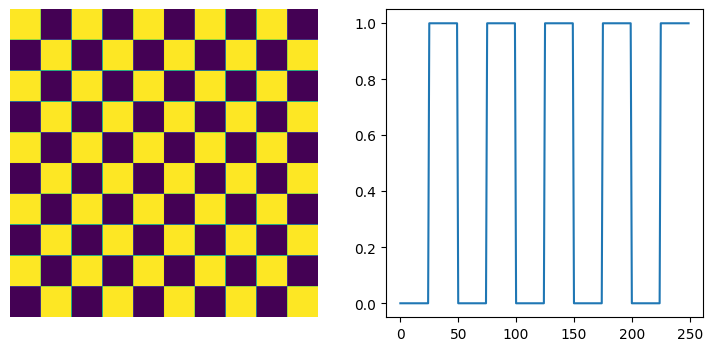

In [4]:
# @title
def generate_checkerboard(rows, cols, box_size):
    # Calculate the overall size of the checkerboard in pixels
    pattern_size = (rows * box_size, cols * box_size)

    # Create the checkerboard pattern using NumPy
    checkerboard = np.zeros(pattern_size)
    for i in range(rows):
        for j in range(cols):
            if (i + j) % 2 == 0:
                checkerboard[i * box_size:(i + 1) * box_size,
                             j * box_size:(j + 1) * box_size] = 1  # Set to white

    return checkerboard

# Parameters
n = 10
rows = n         # Number of rows of boxes
cols = n         # Number of columns of boxes
box_size = 256 // n    # Size of each box in pixels

# Generate the checkerboard pattern
checkerboard = generate_checkerboard(rows, cols, box_size)

Lx, Ly = np.shape(checkerboard)
fig,ax=plt.subplots(1,2,figsize=[9,4])
# Display the checkerboard
ax[0].imshow(checkerboard)
ax[0].axis('off')
ax[1].plot(checkerboard[Lx//2,:])

## Pattern 2: Spirals

Here we generate the ground truth patterns of spirals with adjustable number and with of spins:

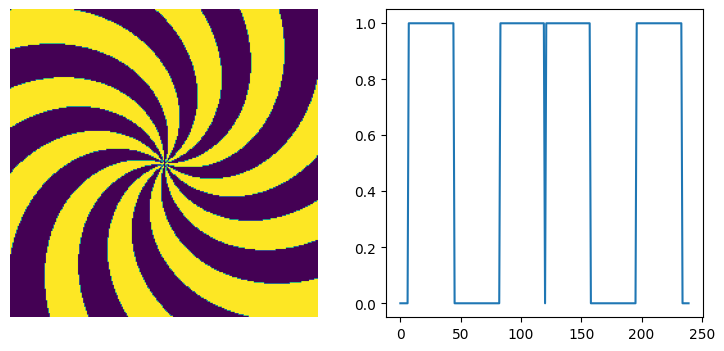

In [5]:
# @title
import numpy as np
import matplotlib.pyplot as plt

def generate_continuous_spiral(rows, cols, box_size, turns=3):
    # Calculate the overall size of the pattern in pixels
    height, width = rows * box_size, cols * box_size
    # Create an empty array for the pattern
    spiral = np.zeros((height, width))

    # Find the center of the pattern
    center_x, center_y = width // 2, height // 2

    # Generate the spiral pattern using polar coordinates
    for x in range(width):
        for y in range(height):
            # Calculate the distance and angle from the center
            dx, dy = x - center_x, y - center_y
            distance = np.sqrt(dx**2 + dy**2)
            angle = np.arctan2(dy, dx)

            # Generate a continuous spiral effect
            # Adjust frequency by `turns`, which determines the number of spiral turns
            spiral_value = 0.5 * (1 + np.sin(distance / box_size + turns * angle))
            # spiral_value = 1
            spiral[y, x] = spiral_value  # Assign grayscale value between 0 and 1
        spiral[np.where(spiral>0.5)] = 1
        spiral[np.where(spiral<=0.5)] = 0
    return spiral

# Parameters
n = 20
rows = n          # Number of rows of boxes (for overall height)
cols = n          # Number of columns of boxes (for overall width)
box_size = 256 // n       # Controls the width of the spiral lines
turns = 10          # Number of turns for the spiral

# Generate the continuous spiral pattern
spiral = generate_continuous_spiral(rows, cols, box_size, turns)

Lx, Ly = np.shape(spiral)
fig,ax=plt.subplots(1,2,figsize=[9,4])
# Display the checkerboard
ax[0].imshow(spiral)
ax[0].axis('off')
ax[1].plot(spiral[Lx//2,:])


## Pattern 3: atomic lattice

Here we generate the ground truth patterns of atomic lattice (cubic) with adjustable density of atoms:

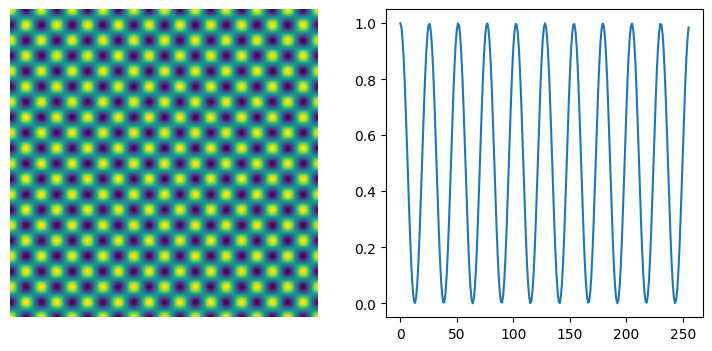

In [6]:
# @title
def generate_atomic_lattice(rows, cols, num_atoms=20):
    # Calculate the overall size of the pattern in pixels
    kx = 2*np.pi/rows * num_atoms
    ky = 2*np.pi/cols * num_atoms
    x = np.arange(rows)
    y = np.arange(cols)
    X, Y = np.meshgrid(x,y)
    return np.cos(kx*X)*np.cos(ky*Y) / 2 + 0.5

# Parameters
n = 256
rows = n          # Number of pixels along x
cols = n          # Number of pixels along y
num_atoms = 10      # number of atoms along the x-direction

# Generate the continuous spiral pattern
atomic_lattice = generate_atomic_lattice(rows, cols, num_atoms)

Lx, Ly = np.shape(atomic_lattice)
fig,ax=plt.subplots(1,2,figsize=[9,4])
# Display the checkerboard
ax[0].imshow(atomic_lattice)
ax[0].axis('off')
ax[1].plot(atomic_lattice[Lx//2,:])

## Pattern 4: a real topography map

Here we generate the ground truth pattern based on experimentally acquired topography image:

In [7]:
!gdown 1uOi187WJ0hMF4R9d0ap4GYnw4e6RjhBK

Downloading...
From: https://drive.google.com/uc?id=1uOi187WJ0hMF4R9d0ap4GYnw4e6RjhBK
To: /content/topo.txt
100% 1.64M/1.64M [00:00<00:00, 113MB/s]


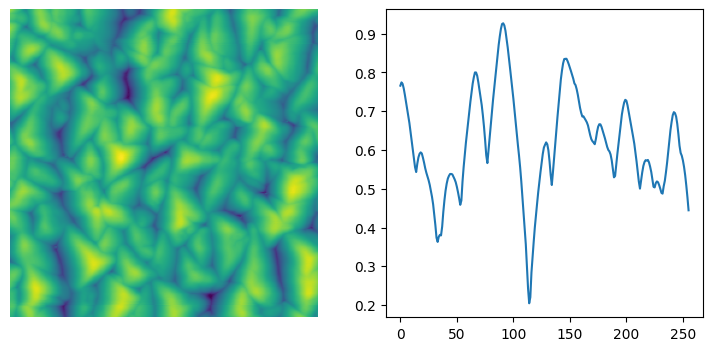

In [8]:
topo = np.loadtxt('topo.txt')

Lx, Ly = np.shape(topo)
fig,ax=plt.subplots(1,2,figsize=[9,4])
# Display the checkerboard
ax[0].imshow(topo)
ax[0].axis('off')
ax[1].plot(topo[Lx//2,:])

## Tip Kernel 1: single-tip with different radius

This is an ideal tip shape: single Gaussian peak with small radius

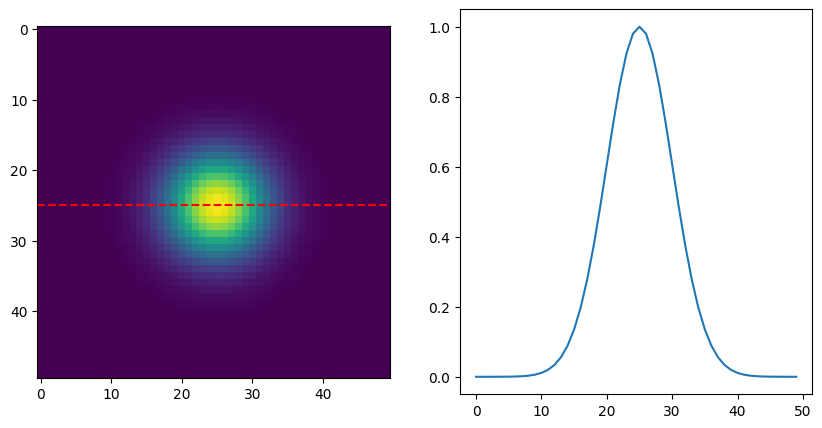

In [9]:
# @title
def generate_tip_kernel(kernel_size=50, wx=5, wy=5, tip_height=1):
    # Kernel size in pixels
    nx, ny = kernel_size, kernel_size

    center1 = np.array([nx//2, ny//2])

    x = np.arange(nx)
    y = np.arange(ny)
    X, Y = np.meshgrid(x, y)

    return np.exp(-((X-center1[0])**2/(2*wx**2) + (Y-center1[1])**2/(2*wy**2))) * tip_height

kernel_size = 50
wx = 5   # x width of the probe
wy = 5   # y width of the probe

kernel_1 = generate_tip_kernel(kernel_size, wx, wy)
Lx, Ly = np.shape(kernel_1)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(kernel_1)
ax[0].axhline(Lx//2, color='r', linestyle='--')
ax[1].plot(kernel_1[Lx//2])

## Tip Kernel 2: double-tip with different separation and relative height

This is a kernel for double-tip:

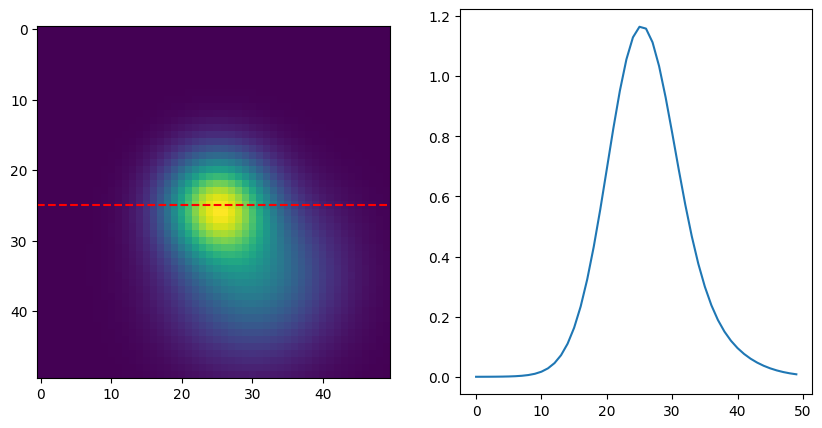

In [10]:
# @title
def generate_doubletip_kernel(kernel_size=50, offset=[1,0], tip1=[5,5,1], tip2=[5,9,0.5]):
    '''
    Generate the kernel for double tip, with tip1: [x_width, y_width, tip_height]
    The two tips are separated by offset.
    Everything is in the unit of pixels.
    '''
    # Kernel size in pixels
    nx, ny = kernel_size, kernel_size

    wx1, wy1, amp1 = tip1
    wx2, wy2, amp2 = tip2
    center1 = np.array([nx//2, ny//2])
    center2 = np.array([nx//2, ny//2]) + np.array(offset)

    x = np.arange(nx)
    y = np.arange(ny)
    X, Y = np.meshgrid(x, y)

    return np.exp(-((X-center1[0])**2/(2*wx1**2) + (Y-center1[1])**2/(2*wy1**2))) * amp1 + \
            np.exp(-((X-center2[0])**2/(2*wx2**2) + (Y-center2[1])**2/(2*wy2**2))) * amp2

kernel_size = 50
wx1 = 5   # x width of the probe 1
wy1 = 5   # y width of the probe 1
amp1 = 1  # amplitude for probe 1

wx2 = 7.5   # x width of the probe 2
wy2 = 7.5   # y width of the probe 2
amp2 = 0.5  # amplitude for probe 2

offset = [5, 10]

kernel_2 = generate_doubletip_kernel(kernel_size, offset,[wx1, wy1, amp1], [wx2, wy2, amp2])
Lx, Ly = np.shape(kernel_2)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(kernel_2)
ax[0].axhline(Lx//2, color='r', linestyle='--')
ax[1].plot(kernel_2[Lx//2])

# Simulate the imaging process

## Pattern 1 with perfect and imperfect tips

Generate the checkboard pattern:

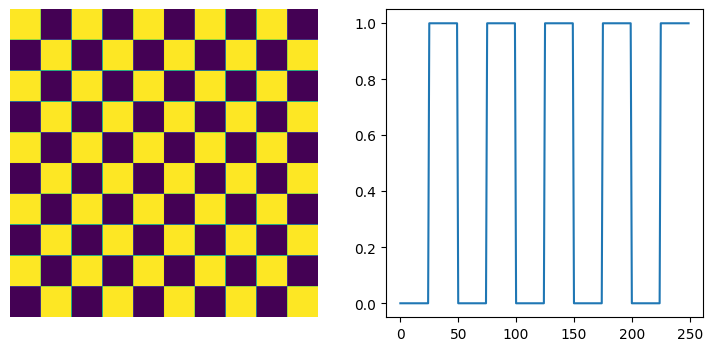

In [11]:
# @title
# Parameters
n = 10
rows = n         # Number of rows of boxes
cols = n         # Number of columns of boxes
box_size = 256 // n    # Size of each box in pixels

# Generate the checkerboard pattern
checkerboard = generate_checkerboard(rows, cols, box_size)

Lx, Ly = np.shape(checkerboard)
fig,ax=plt.subplots(1,2,figsize=[9,4])
# Display the checkerboard
ax[0].imshow(checkerboard)
ax[0].axis('off')
ax[1].plot(checkerboard[Lx//2,:])

Scan the ground truth pattern with a real probe:

Text(0.5, 1.0, 'Image with real tip')

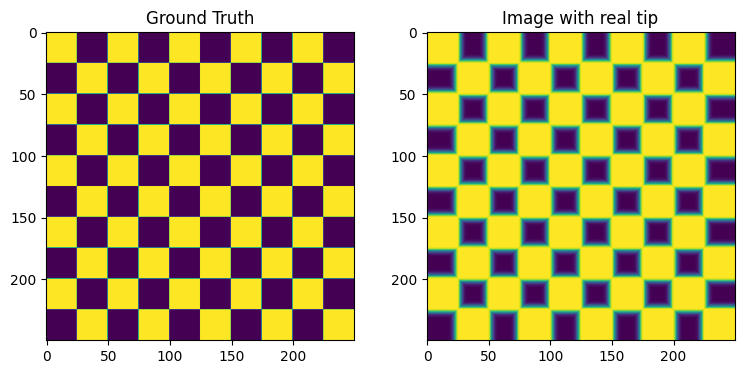

In [12]:
# @title
# Scanning with a real tip

kernel_size = 50
wx = 2.5   # x width of the probe
wy = 2.5   # y width of the probe

kernel_1 = generate_tip_kernel(kernel_size, wx, wy)

z_checkerboard = scanning(checkerboard, kernel_1)

fig, ax=plt.subplots(1,2,figsize=[9,4])
ax[0].imshow(checkerboard)
ax[1].imshow(z_checkerboard)

ax[0].set_title('Ground Truth')
ax[1].set_title('Image with real tip')

Now let's add the effect of PID settings:

Text(0.5, 1.0, 'Image with real tip with PID')

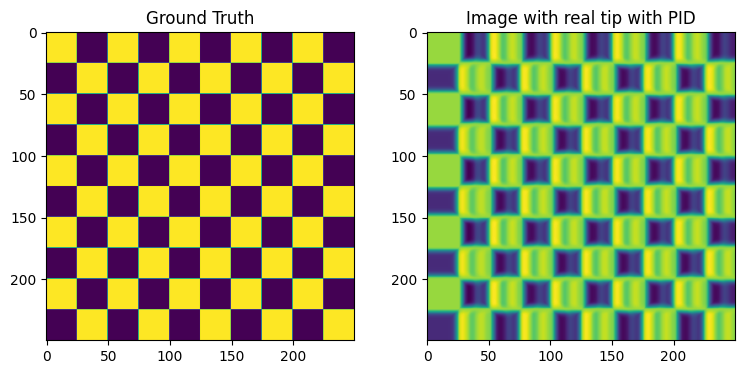

In [13]:
# Scanning with a real tip and real PID settings

z_checkerboard_PID = pi_loop(z_checkerboard, P=0.5, I=1e-1)

fig, ax=plt.subplots(1,2,figsize=[9,4])
ax[0].imshow(checkerboard)
ax[1].imshow(z_checkerboard_PID)

ax[0].set_title('Ground Truth')
ax[1].set_title('Image with real tip with PID')

# Simulate the probe and setting changes in the middle of a scan

## Let's simulate a sudden change to the probe in the middle of the scanning

Define the function to simulate the tip change effect:

- We need to provide kernel1 (tip shape before change), pi1 ([P, I] before the tip change), kernel2 (optional, tip shape after tip change), pi2(optional, [P, I] after the tip change)
- Basically, the function will randomly select a point in the map, and all the pixels after this "tip change point" will be simulated based on the kernel2 and pi2 parameters

In [14]:
# @title
def scanning_tip_change(img, kernel1, pi1, kernel2=None, pi2=None):
    '''
    Simulate the scanning with tip change and/or PI setting changes.
    Input:
        img: ground truth image pattern
        kernel1: tip kernel before tip change event
        kernel2: tip kernel after tip change event. If not provided, will be the same as kernel1
        pi1: [P, I] settings for the PI before tip change event
        pi2: [P, I] settings for the PI after tip change event. If not provided, will be the same as pi1
    '''
    if kernel2 is None:
        kernel2 = kernel1
    if pi2 is None:
        pi2 = pi1
    out1 = pi_loop(scanning(img, kernel1), P=pi1[0], I=pi1[1])
    out2 = pi_loop(scanning(img, kernel2), P=pi2[0], I=pi2[1])

    nx, ny = np.shape(out1)

    index = random.randint(0, nx * ny)

    out1 = out1.flatten()
    out1[index:] = out2.flatten()[index:]

    return out1.reshape([nx, ny])

Define the two kernels. Here the tip after change is more blunt and shorter compared to the original tip:

In [15]:
# @title
# Say that the probe changed its height during the scanning

kernel_size = 50
wx = 2.5   # x width of the probe
wy = 2.5   # y width of the probe

# Initial tip kernel
kernel_1 = generate_tip_kernel(kernel_size, wx, wy, tip_height=1)

# Tip kernel after tip change
kernel_2 = generate_tip_kernel(kernel_size, wx=5, wy=5, tip_height=0.5)

Text(0.5, 1.0, 'Image with tip change')

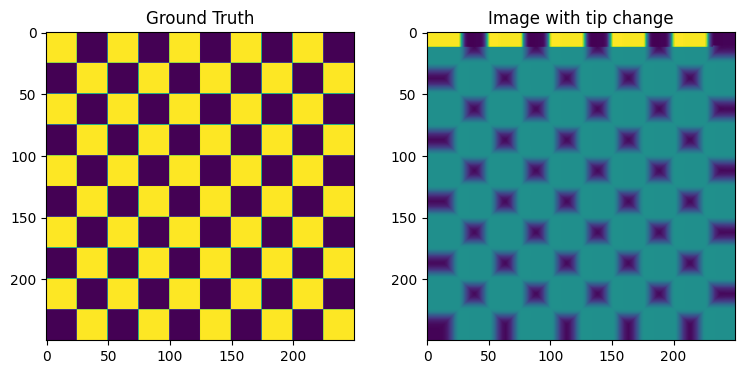

In [16]:
# @title
# Scanning with a real tip and real PID settings with tip change

z_tip_change = scanning_tip_change(checkerboard, kernel_1, pi1=[1, 1e-2], kernel2=kernel_2, pi2=None)

fig, ax=plt.subplots(1,2,figsize=[9,4])
ax[0].imshow(checkerboard)
ax[1].imshow(z_tip_change)

ax[0].set_title('Ground Truth')
ax[1].set_title('Image with tip change')

## Tip change from single to double tip

Here the tip after change becomes double and we also changed the PID settings after the tip change:

In [17]:
# @title
# Say that the probe changed its height during the scanning

kernel_size = 50
wx = 2.5   # x width of the probe
wy = 2.5   # y width of the probe

# Initial tip kernel
kernel_1 = generate_tip_kernel(kernel_size, wx, wy, tip_height=1)

kernel_size = 50
wx1 = 2.5   # x width of the probe 1
wy1 = 2.5   # y width of the probe 1
amp1 = 1  # amplitude for probe 1

wx2 = 2.5   # x width of the probe 2
wy2 = 2.5   # y width of the probe 2
amp2 = 0.5  # amplitude for probe 2

offset = [5, 10]

kernel_2 = generate_doubletip_kernel(kernel_size, offset,[wx1, wy1, amp1], [wx2, wy2, amp2])

Text(0.5, 1.0, 'Image with tip change')

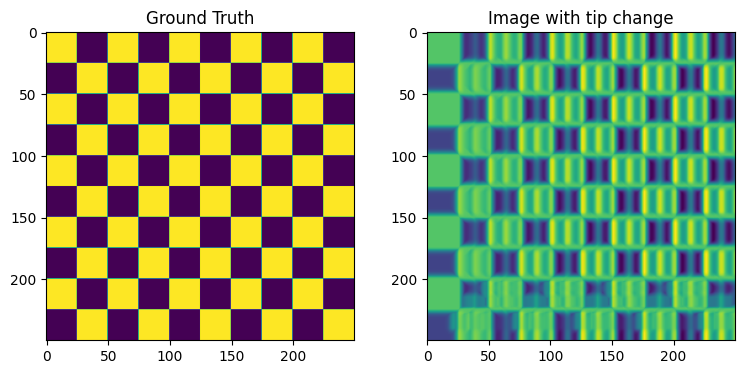

In [18]:
# @title
# Scanning with a real tip and real PID settings
# Here the tip changes from single-tip to a double tip

z_tip_change = scanning_tip_change(checkerboard, kernel_1, pi1=[0.7, 3e-1], kernel2=kernel_2, pi2=None)

fig, ax=plt.subplots(1,2,figsize=[9,4])
ax[0].imshow(checkerboard)
ax[1].imshow(z_tip_change)

ax[0].set_title('Ground Truth')
ax[1].set_title('Image with tip change')

# Generate the phase map according to the realtime tip-sample distance

## Define the ideal phase -- distance relation

<ipython-input-19-318f5b2fd93e>:11: RuntimeWarning: invalid value encountered in arccos
  -np.arccos(x) * 50 + 90,
<ipython-input-19-318f5b2fd93e>:12: RuntimeWarning: invalid value encountered in arccos
  np.where(x < 1, np.arccos(x) * 50 + 90, 90)


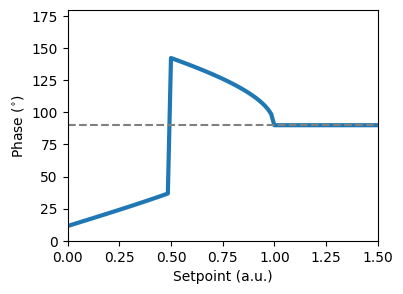

In [19]:
# phase depends on
# 1, free-air amplitude
# 2, tip-sample distance (setpoint)


t = np.linspace(0, 1.5, num=100)

def generate_phase(x, setpoint=0.5):
    return np.where(
        x < setpoint,
        -np.arccos(x) * 50 + 90,
        np.where(x < 1, np.arccos(x) * 50 + 90, 90)
    )

out = generate_phase(t)

plt.figure(figsize=[4,3])
plt.plot(t, out, lw=3)
plt.xlim(0, 1.5)
plt.ylim(0, 180)
# plt.xticks([])
plt.xlabel('Setpoint (a.u.)')
plt.ylabel('Phase ($^{\circ}$)')
plt.axhline(90, linestyle='--', color='gray')

# plt.savefig('figs/expected phase thicker line.png', dpi=400, bbox_inches='tight', pad_inches=0.1)

In [20]:
generate_phase(0.2, 0.5)

array(21.5280797)

<ipython-input-19-318f5b2fd93e>:11: RuntimeWarning: invalid value encountered in arccos
  -np.arccos(x) * 50 + 90,
<ipython-input-19-318f5b2fd93e>:12: RuntimeWarning: invalid value encountered in arccos
  np.where(x < 1, np.arccos(x) * 50 + 90, 90)


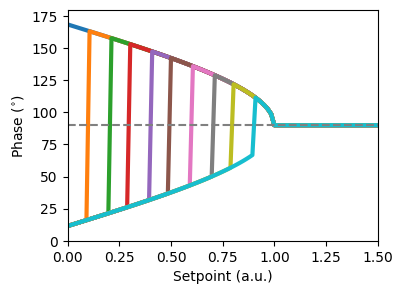

In [21]:
setpoints = np.arange(10) / 10

t = np.linspace(0, 1.5, num=100)

phases = np.zeros([len(setpoints), len(t)])

for i, setpoint in enumerate(setpoints):
    phases[i, :] = generate_phase(t, setpoint)

plt.figure(figsize=[4,3])

for i in range(len(setpoints)):
    plt.plot(t, phases[i, :], lw=3, label=f'Setpoint = {setpoints[i]}')

plt.xlim(0, 1.5)
plt.ylim(0, 180)
plt.xlabel('Setpoint (a.u.)')
plt.ylabel('Phase ($^{\circ}$)')
plt.axhline(90, linestyle='--', color='gray')
# plt.plot(t, phases.T, lw=3)
# plt.xlim(0, 1.5)
# plt.ylim(0, 180)

## Implement new scanning function that integrates tip shape, PI settings, and scan speed

In [22]:
# @title
# Pre-define scan funstions

norm_ = lambda x: (x - np.min(x)) / np.ptp(x) * 1

@jit(nopython=True, parallel=True)
def pad_image(image, pad_height, pad_width):
    '''
    Pad the image with -1 on the four edges to make sure we can run the kernel through all the pixels.
    Inputs:
        image:    -ndarray: 2D image array to be simulated based on
        pad_height -int: kernel_height // 2
        pad_width  -int:  kernel_width // 2
    Outputs:
        padded_image -ndarray: 2D image array with edge extented by padding -1
    '''
    image_height, image_width = image.shape
    padded_height = image_height + 2 * pad_height
    padded_width = image_width + 2 * pad_width
    padded_image = -np.ones((padded_height, padded_width))  # Use constant value -1 for padding

    for i in prange(image_height):
        for j in prange(image_width):
            padded_image[i + pad_height, j + pad_width] = image[i, j]

    return padded_image

@jit(nopython=True, parallel=True)
def scanning(image, kernel):
    '''
    Scanning image simulated with real probe shapes defined by the kernel.
    '''
    # image = norm_(image)
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    padded_image = pad_image(image, pad_height, pad_width)

    output = np.zeros((image_height, image_width))

    for i in prange(image_height):
        for j in prange(image_width):
            crop = padded_image[i:i + kernel_height, j:j + kernel_width]
            output[i, j] = 1 - np.min(2 - kernel - crop)

    return output

In [23]:
# @title
class FixedLengthStack:
    '''
    Numpy circular stack with adjustable length to store
    '''
    def __init__(self, length=10):
        self.buffer = np.zeros(length, dtype=np.float64)  # Initialize with zeros or any default value
        self.length = length
        self.index = 0
        self.full = False

    def append(self, value):
        self.buffer[self.index] = value
        self.index = (self.index + 1) % self.length
        if self.index == 0:
            self.full = True

    def get_stack(self):
        if not self.full:
            return self.buffer[:self.index]
        return np.concatenate((self.buffer[self.index:], self.buffer[:self.index]))

    def sum_stack(self):
        if not self.full:
            return np.sum(self.buffer[:self.index])
        return np.sum(self.buffer)

# @title
def pi_loop(trace, setpoint=0.1, P=1e0, I=1e-2, z_0=0.1, length=10):
    output = np.zeros_like(trace)

    if len(np.shape(trace)) == 1:
        output[0] = trace[0] + setpoint

        integral = FixedLengthStack(length=length)
        for i in range(len(trace)-1):
            z_diff = output[i]-trace[i]-z_0
            integral.append(z_diff)
            output[i+1] = output[i] - P*(z_diff) - I*integral.sum_stack()
        return output
    elif len(np.shape(trace)) == 2:
        for index in range(len(trace)):
            output[index, 0] = trace[index, 0] + setpoint
            integral = FixedLengthStack(length=length)
            for i in range(len(trace[index])-1):
                z_diff = output[index, i]-trace[index, i]-z_0
                integral.append(z_diff)
                output[index, i+1] = output[index, i] - P*(z_diff) - I*integral.sum_stack()
        return output

**Here is how we compute the realistic scans with different parameters:**

1. the tip kernel accounts for the tip shape effect
2. drive amplitude and setpoint amplitude together determines the phase response
3. P, I, z_speed and scan_speed together determines the effect of scan speed, finite z scanner speed, and finite PI response speed effect
4. This is how it works:
  * At a new pixel, the __target__ tip position is given by the PID algorithm and the setpoint amplitude, with the consideration of tip shape and retarded effect
  * The __measured__ tip position on the other hand is determined by the last pixel tip position $s_{i-1}$, new target tip position $s_i$, scan spped (tip movement speed) $v_{tip}$, and tip extend/retraction spped $v_z$
  * Only the measured tip positions are stored in the PID "FixedLengthStack"
  * The phase map is computed in the real time by the __measured__ tip-sample distance
  * Also, the tip changes are easier to occur at small tip sample distance
  * Finally, the retrace map is generated by feeding the flipped ground truth image to the same scan function

In [24]:
# @title
# # @title
# class FixedLengthStack:
#     '''
#     Numpy circular stack with adjustable length to store
#     '''
#     def __init__(self, length=10):
#         self.buffer = np.zeros(length, dtype=np.float64)  # Initialize with zeros or any default value
#         self.length = length
#         self.index = 0
#         self.full = False

#     def append(self, value):
#         self.buffer[self.index] = value
#         self.index = (self.index + 1) % self.length
#         if self.index == 0:
#             self.full = True

#     def get_stack(self):
#         if not self.full:
#             return self.buffer[:self.index]
#         return np.concatenate((self.buffer[self.index:], self.buffer[:self.index]))

#     def sum_stack(self):
#         if not self.full:
#             return np.sum(self.buffer[:self.index])
#         return np.sum(self.buffer)

# @jit(nopython=True, parallel=True)
# def scan(image, kernel, drive=0.5, setpoint=0.2, P=1e0, I=1e-2, length=10, z_speed=0.1, scan_speed=1, phase=False, retrace=False):
#     '''
#     Generate realistic scan images based on the ground truth image, tip shape kernel, and scanning parameters.
#     Input:
#         image  - ndarray: ground truth 1D or 2D image profile
#         kernel - ndarray: tip shape kernel
#         drive  - float: the drive amplitude (free-air amplitude)
#         setpoint - float: setpoint amplitude (setpoint tip-sample distance in the simulator)
#         P - float: proportional gain in PID
#         I - float: integral gain in PID
#         length - int: the number of pixels in "memory" of PID algorithm
#         z_speed - float: the extend/retrace speed of the z piezo
#         scan_speed - float: the xy movement speed of the tip
#         phase - boolean: if true, a corresponding phase map is generated along with the height map
#         retrace - boolean: if true, both trace and retrace maps will be generated

#     output:
#         Realistic scan image generated based on ground truth image, tip shape kernel, and scanning parameters.
#     '''
#     # image = norm_(image)
#     image_height, image_width = image.shape
#     kernel_height, kernel_width = kernel.shape

#     pad_height = kernel_height // 2
#     pad_width = kernel_width // 2

#     # pad the boundaries with -1
#     padded_image = pad_image(image, pad_height, pad_width)

#     z_groundtruth = np.zeros((image_height, image_width))

#     # Generate the ground truth map with tip kernels
#     for i in prange(image_height):
#         for j in prange(image_width):
#             crop = padded_image[i:i + kernel_height, j:j + kernel_width]
#             z_groundtruth[i, j] = 1 - np.min(2 - kernel - crop)

#     # output = np.zeros_like(image)
#     z_cal = np.zeros_like(image)
#     z_measured = np.zeros_like(image)
#     # max tip height change computed from the scan speed and z_speed:
#     # delta_t = 1 / scan_speed
#     delta_z_max = z_speed / scan_speed
#     # Scan speed and PID effect
#     integral = FixedLengthStack(length=length)
#     for index in range(len(z_groundtruth)):
#         z_cal[index, 0] = z_groundtruth[index, 0] + setpoint
#         z_measured[index, 0] = z_groundtruth[index, 0] + setpoint
#         integral = FixedLengthStack(length=length)
#         for i in range(len(z_groundtruth[index])-1):
#             z_diff_cal = z_measured[index, i]-z_groundtruth[index, i]-setpoint
#             # Compare the height difference to move with the max. height movement value
#             # if np.abs(z_diff_cal) < delta_z_max:
#             #     z_diff_measured = z_diff_cal
#             # else:
#             #     z_diff_measured = delta_z_max
#             integral.append(z_diff_cal)
#             distance_to_move = P*(z_diff_cal) + I*integral.sum_stack()
#             if np.abs(distance_to_move) > delta_z_max:
#                 distance_to_move = delta_z_max
#             z_measured[index, i+1] = z_measured[index, i] - distance_to_move
#     if phase is False:
#         return z_measured
#     # Compute the phsae map
#     else:
#         phase_map = generate_phase(z_measured - z_groundtruth, drive)
#         return z_measured, phase_map

In [25]:
import numpy as np
from numba import jit, prange

# @title
class FixedLengthStack:
    '''
    Numpy circular stack with adjustable length to store
    '''
    def __init__(self, length=10):
        self.buffer = np.zeros(length, dtype=np.float64)  # Initialize with zeros or any default value
        self.length = length
        self.index = 0
        self.full = False

    def append(self, value):
        self.buffer[self.index] = value
        self.index = (self.index + 1) % self.length
        if self.index == 0:
            self.full = True

    def get_stack(self):
        if not self.full:
            return self.buffer[:self.index]
        return np.concatenate((self.buffer[self.index:], self.buffer[:self.index]))

    def sum_stack(self):
        if not self.full:
            return np.sum(self.buffer[:self.index])
        return np.sum(self.buffer)


# @jit(nopython=True, parallel=True)
def generate_phase(x, setpoint=0.5):
    return np.where(
        x < setpoint,
        -np.arccos(x) * 50 + 90,
        np.where(x < 1, np.arccos(x) * 50 + 90, 90)
    )

# @jit(nopython=True, parallel=True)
def scan(image, kernel, drive=0.5, setpoint=0.2, P=1e0, I=1e-2, length=10, z_speed=0.1, scan_speed=1,
         phase=False, retrace=False):
    '''
    Generate realistic scan images based on the ground truth image, tip shape kernel, and scanning parameters.
    Input:
        image  - ndarray: ground truth 1D or 2D image profile
        kernel - ndarray: tip shape kernel
        drive  - float: the drive amplitude (free-air amplitude)
        setpoint - float: setpoint amplitude (setpoint tip-sample distance in the simulator)
        P - float: proportional gain in PID
        I - float: integral gain in PID
        length - int: the number of pixels in "memory" of PID algorithm
        z_speed - float: the extend/retrace speed of the z piezo
        scan_speed - float: the xy movement speed of the tip
        phase - boolean: if true, a corresponding phase map is generated along with the height map
        retrace - boolean: if true, both trace and retrace maps will be generated

    output:
        Realistic scan image generated based on ground truth image, tip shape kernel, and scanning parameters.
    '''
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    # pad the boundaries with -1
    padded_image = pad_image(image, pad_height, pad_width)

    z_groundtruth = np.zeros((image_height, image_width))

    # Generate the ground truth map with tip kernels
    for i in prange(image_height):
        for j in prange(image_width):
            crop = padded_image[i:i + kernel_height, j:j + kernel_width]
            z_groundtruth[i, j] = 1 - np.min(2 - kernel - crop)

    z_cal = np.zeros_like(image)
    z_measured = np.zeros_like(image)
    delta_z_max = z_speed / scan_speed

    # Initialize PID integral stack using a NumPy array instead of the custom class
    integral = np.zeros(length)

    for index in range(len(z_groundtruth)):
        z_cal[index, 0] = z_groundtruth[index, 0] + setpoint
        z_measured[index, 0] = z_groundtruth[index, 0] + setpoint

        for i in range(len(z_groundtruth[index])-1):
            z_diff_cal = z_measured[index, i] - z_groundtruth[index, i] - setpoint

            # Update integral (shift left and add new value)
            integral = np.roll(integral, -1)
            integral[-1] = z_diff_cal

            integral_sum = np.sum(integral)
            distance_to_move = P * z_diff_cal + I * integral_sum

            if np.abs(distance_to_move) > delta_z_max:
                distance_to_move = np.sign(distance_to_move) * delta_z_max

            z_measured[index, i+1] = z_measured[index, i] - distance_to_move
    # Generate the retrace map
    if retrace:
        integral = np.zeros(length)
        z_cal_re = np.zeros_like(image)
        z_measured_re = np.zeros_like(image)

        for index in range(len(z_groundtruth)):
            # For the retrace map, we start from the last pixel to first pixel
            z_cal_re[index, 0] = z_groundtruth[index, -1] + setpoint
            z_measured_re[index, 0] = z_groundtruth[index, -1] + setpoint

            for i in range(len(z_groundtruth[index])-1):
                z_diff_cal_re = z_measured_re[index, i] - z_groundtruth[index][::-1][i] - setpoint

                # Update integral (shift left and add new value)
                integral = np.roll(integral, -1)
                integral[-1] = z_diff_cal_re

                integral_sum = np.sum(integral)
                distance_to_move = P * z_diff_cal_re + I * integral_sum

                if np.abs(distance_to_move) > delta_z_max:
                    distance_to_move = np.sign(distance_to_move) * delta_z_max

                z_measured_re[index, i+1] = z_measured_re[index, i] - distance_to_move
    if phase is False:
        if retrace:
            return z_measured, z_measured_re[:, ::-1]
        else:
            return z_measured
    else:
        phase_map = generate_phase(z_measured - z_groundtruth, drive)
        if retrace:
            phase_map_re = generate_phase(z_measured_re[:,::-1] - z_groundtruth, drive)
            return z_measured, phase_map, z_measured_re[:, ::-1], phase_map_re[:,::-1]
        else:
            return z_measured, phase_map


Text(0.5, 1.0, 'Image with real tip')

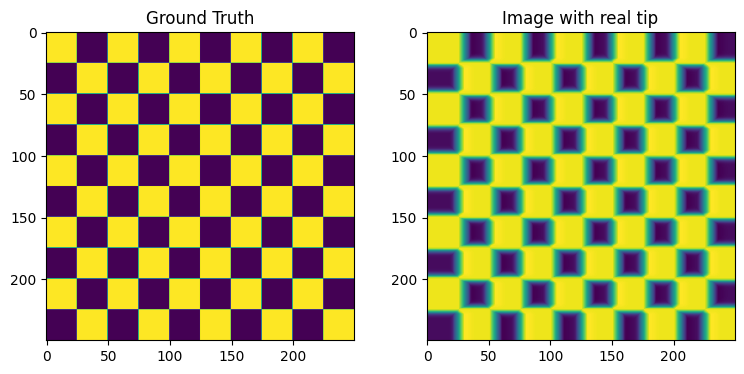

In [26]:
# @title
# Scanning with a real tip

kernel_size = 50
wx = 2.5   # x width of the probe
wy = 2.5   # y width of the probe

kernel_1 = generate_tip_kernel(kernel_size, wx, wy)

z_checkerboard = scan(checkerboard, kernel_1)

fig, ax=plt.subplots(1,2,figsize=[9,4])
ax[0].imshow(checkerboard)
ax[1].imshow(z_checkerboard)

ax[0].set_title('Ground Truth')
ax[1].set_title('Image with real tip')

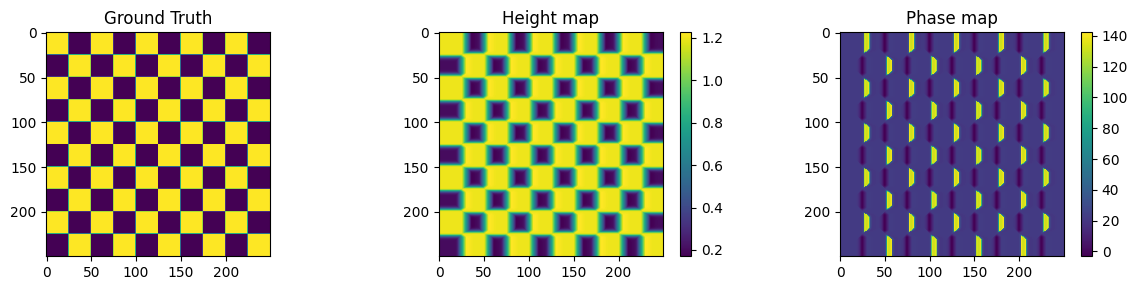

In [27]:
# @title
# Scanning with a real tip

kernel_size = 50
wx = 2.5   # x width of the probe
wy = 2.5   # y width of the probe

kernel_1 = generate_tip_kernel(kernel_size, wx, wy)

z_checkerboard, phase_checkerboard = scan(checkerboard, kernel_1, phase=True)

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z_checkerboard)
im2 = ax[2].imshow(phase_checkerboard)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map')
ax[2].set_title('Phase map')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

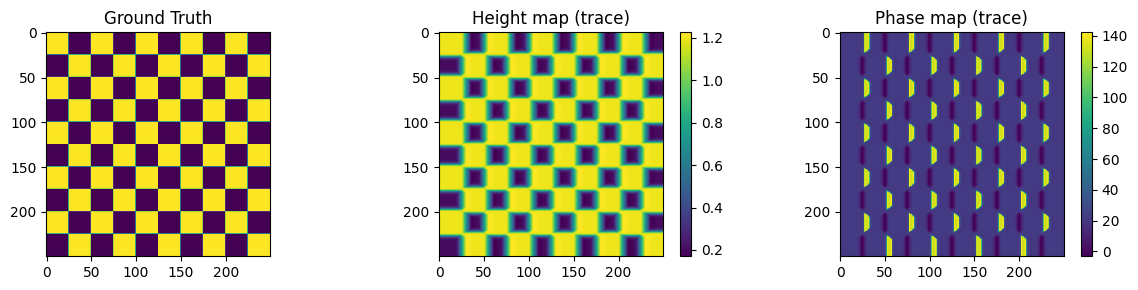

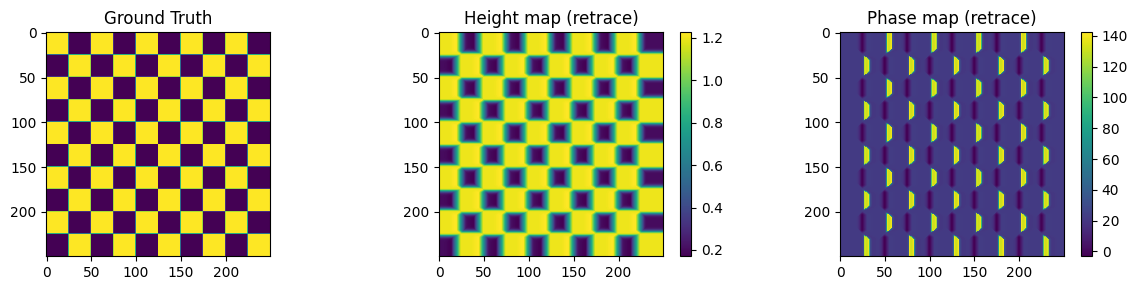

In [28]:
# @title
# Scanning with a real tip

kernel_size = 50
wx = 2.5   # x width of the probe
wy = 2.5   # y width of the probe

kernel_1 = generate_tip_kernel(kernel_size, wx, wy)

z1, ph1, z2, ph2 = scan(checkerboard, kernel_1, phase=True, retrace=True)

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z1)
im2 = ax[2].imshow(ph1)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map (trace)')
ax[2].set_title('Phase map (trace)')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z2)
im2 = ax[2].imshow(ph2)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map (retrace)')
ax[2].set_title('Phase map (retrace)')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

Accelerate the scan() function with numba:

In [29]:
from numba import njit, prange
import numpy as np

@njit
def generate_phase(x, setpoint=0.5):
    return np.where(
        x < setpoint,
        -np.arccos(x) * 50 + 90,
        np.where(x < 1, np.arccos(x) * 50 + 90, 90)
    )

@njit(parallel=True)
def scan(image, kernel, drive=0.5, setpoint=0.2, P=1e0, I=1e-2, length=10, z_speed=0.1, scan_speed=1,
         phase=False, retrace=False):
    '''
    Generate realistic scan images based on the ground truth image, tip shape kernel, and scanning parameters.
    '''
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    # Pad the boundaries with -1
    padded_image = pad_image(image, pad_height, pad_width)

    z_groundtruth = np.zeros((image_height, image_width))

    # Generate the ground truth map with tip kernels
    for i in prange(image_height):
        for j in prange(image_width):
            crop = padded_image[i:i + kernel_height, j:j + kernel_width]
            z_groundtruth[i, j] = 1 - np.min(2 - kernel - crop)

    z_cal = np.zeros_like(image)
    z_measured = np.zeros_like(image)
    delta_z_max = z_speed / scan_speed

    # Initialize placeholder arrays
    z_measured_re = np.zeros_like(image) if retrace else np.zeros((0, 0))
    phase_map = np.zeros_like(image) if phase else np.zeros((0, 0))
    phase_map_re = np.zeros_like(image) if (phase and retrace) else np.zeros((0, 0))

    for index in prange(len(z_groundtruth)):  # Parallel over scan lines
        # Initialize PID integral stack per scan line to avoid shared memory issues
        integral = np.zeros(length)

        # Start scanning from the beginning of each line
        z_cal[index, 0] = z_groundtruth[index, 0] + setpoint
        z_measured[index, 0] = z_groundtruth[index, 0] + setpoint

        for i in range(len(z_groundtruth[index])-1):
            z_diff_cal = z_measured[index, i] - z_groundtruth[index, i] - setpoint

            # Update integral (shift left and add new value)
            integral = np.roll(integral, -1)
            integral[-1] = z_diff_cal

            integral_sum = np.sum(integral)
            distance_to_move = P * z_diff_cal + I * integral_sum

            if np.abs(distance_to_move) > delta_z_max:
                distance_to_move = np.sign(distance_to_move) * delta_z_max

            z_measured[index, i+1] = z_measured[index, i] - distance_to_move

    # Generate retrace map if requested
    if retrace:
        for index in prange(len(z_groundtruth)):  # Parallel over scan lines for retrace
            # Initialize integral stack per scan line
            integral = np.zeros(length)

            z_measured_re[index, 0] = z_groundtruth[index, -1] + setpoint

            for i in range(len(z_groundtruth[index])-1):
                z_diff_cal_re = z_measured_re[index, i] - z_groundtruth[index][::-1][i] - setpoint

                # Update integral (shift left and add new value)
                integral = np.roll(integral, -1)
                integral[-1] = z_diff_cal_re

                integral_sum = np.sum(integral)
                distance_to_move = P * z_diff_cal_re + I * integral_sum

                if np.abs(distance_to_move) > delta_z_max:
                    distance_to_move = np.sign(distance_to_move) * delta_z_max

                z_measured_re[index, i+1] = z_measured_re[index, i] - distance_to_move

    # Generate phase map if requested
    if phase:
        phase_map = generate_phase(z_measured - z_groundtruth, drive)
        if retrace:
            phase_map_re = generate_phase(z_measured_re[:, ::-1] - z_groundtruth, drive)

    return z_measured, phase_map, z_measured_re, phase_map_re


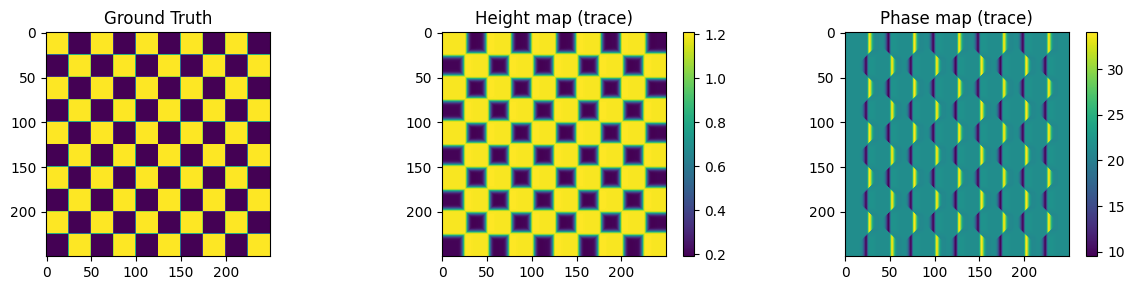

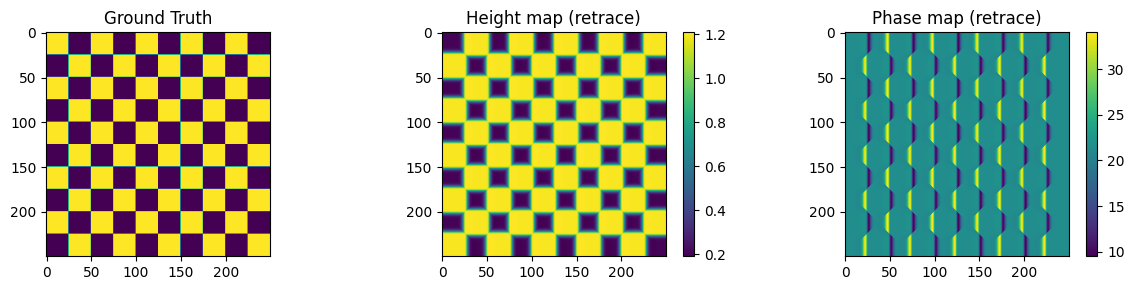

In [36]:
# @title
# Scanning with a real tip

kernel_size = 50
wx = 2.5   # x width of the probe
wy = 2.5   # y width of the probe

kernel_1 = generate_tip_kernel(kernel_size, wx, wy)

z1, ph1, z2, ph2 = scan(checkerboard, kernel_1, phase=True, retrace=True, scan_speed=0.1)

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z1)
im2 = ax[2].imshow(ph1)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map (trace)')
ax[2].set_title('Phase map (trace)')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z2)
im2 = ax[2].imshow(ph2)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map (retrace)')
ax[2].set_title('Phase map (retrace)')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

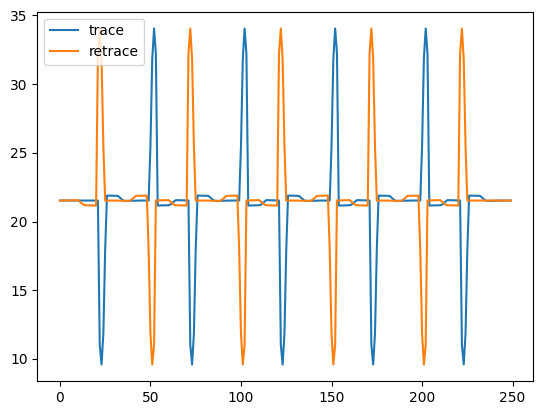

In [37]:
plt.plot(ph1[128], label='trace')
plt.plot(ph2[128], label='retrace')
plt.legend()

# Realistic tip changes -- with the new scan() function

In [32]:
#